OpenProblems / NeurIPS 2021 competition for multimodal single-cell data integration

https://github.com/openproblems-bio/neurips2021_multimodal_topmethods

In [1]:
import numpy as np
import pandas as pd

import os, gc, pickle, json

import matplotlib.pyplot as plt
from colorama import Fore, Back, Style
from matplotlib.ticker import MaxNLocator

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import tensorflow as tf
#tf.keras.backend.clear_session()

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)

from config import *

2022-10-31 09:32:10.255938: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/hadoop/lib/native/:/usr/local/cuda-9.0/targets/x86_64-linux/lib/:/usr/local/cuda-9.0/targets/x86_64-linux/lib64/:/usr/hadoop/lib/native/:/usr/local/cuda-9.0/targets/x86_64-linux/lib/:/usr/local/cuda-9.0/targets/x86_64-linux/lib64/::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/hadoop/lib/native:/usr/hadoop/lib/native/Linux-amd64-64
2022-10-31 09:32:10.255970: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TF version: 2.6.0
TFP version: 0.14.0


In [33]:
DATA_DIR = os.path.join(PATH_WORKING, 'data_cite_x512')
MODEL_DIR_nn = os.path.join(PATH_WORKING, 'nn_cite_x512')
MODEL_DIR_lgb = os.path.join(PATH_WORKING, 'lgb_cite_x512')

In [34]:
y_true = pd.read_hdf(FP_CITE_TRAIN_TARGETS).values.astype('float32') 

In [35]:
mse_nn = np.zeros((140,))
mse_lgb = np.zeros((140,))

for k, (train_index, test_index) in enumerate(KFold(n_splits=10, shuffle=True, random_state=SEED*4).split(y_true)):

    y_fold_true = y_true[test_index]

    y_fold_nn = np.load(os.path.join(MODEL_DIR_nn, f'y_fold_{k}.npy'))
    y_fold_lgb = np.load(os.path.join(MODEL_DIR_lgb, f'y_fold_{k}.npy'))
    
    assert y_fold_true.shape == y_fold_nn.shape
    assert y_fold_true.shape == y_fold_lgb.shape
    assert y_fold_nn.shape == y_fold_lgb.shape
    
    # fix bounds for preds
    lb = np.min(y_fold_true, axis=0, keepdims=True)
    ub = np.max(y_fold_true, axis=0, keepdims=True)
    y_fold_nn = np.clip(y_fold_nn, lb, ub)
    y_fold_lgb = np.clip(y_fold_lgb, lb, ub)
    
    erros_nn = (y_fold_true - y_fold_nn)**2
    erros_lgb = (y_fold_true - y_fold_lgb)**2
    
    mse_nn += np.mean(erros_nn, axis=0)
    mse_lgb += np.mean(erros_lgb, axis=0)

mse_nn /= 10
mse_lgb /= 10

In [41]:
idx = np.where(mse_lgb < mse_nn)[0]
print(len(idx))
idx

81


array([  0,   3,   4,   5,   6,   7,   8,   9,  13,  14,  15,  16,  17,
        18,  20,  21,  24,  28,  29,  30,  37,  42,  43,  44,  45,  48,
        50,  51,  52,  54,  55,  57,  58,  60,  61,  64,  68,  69,  70,
        71,  73,  75,  77,  79,  80,  81,  82,  86,  88,  89,  91,  92,
        94,  95,  97,  99, 100, 104, 106, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 121, 127, 130, 131, 133, 134, 136,
       137, 138, 139])

In [37]:
y_fold_true

array([[ 2.0027757 , -0.14023319, -0.04327662, ...,  0.36001372,
        -1.2928327 ,  1.597052  ],
       [-0.28304344,  0.04797234,  0.14927372, ..., -0.20170508,
         1.2102768 ,  6.675041  ],
       [-0.71534777, -0.49915326, -0.41048253, ..., -0.7506912 ,
         1.5325812 ,  1.217305  ],
       ...,
       [-0.41715258,  1.7934265 ,  0.06119077, ...,  0.6489624 ,
         1.8710786 ,  3.0164864 ],
       [-0.23028766,  0.3895501 ,  1.3501713 , ..., -0.444369  ,
         2.7940578 ,  4.698568  ],
       [-0.14509758, -0.34723133,  1.6988021 , ...,  1.0188603 ,
         1.8840111 ,  5.6001663 ]], dtype=float32)

In [42]:
idxs = np.where(y_fold_nn < 0)
y_fold_nn[idxs[0], idxs[1]]

array([-0.22213432, -0.12991849, -0.01208161, ..., -0.19248216,
       -0.12941684, -0.5071277 ], dtype=float32)

In [25]:
idxs = np.where(y_fold_lgb < 0)
y_fold_lgb[idxs[0], idxs[1]]

array([-0.02166236, -0.09636224, -0.01011171, ..., -0.01659816,
       -0.0649613 , -0.01141472])

Text(0.5, 1.0, 'Evolution of val_loss')

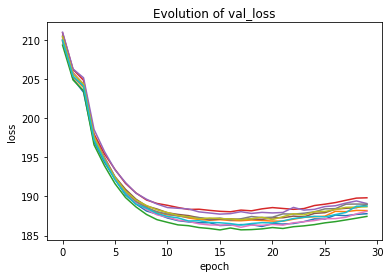

In [2]:
MODEL_DIR = os.path.join(PATH_WORKING, 'pdl_cite_x512')

fig, ax = plt.subplots()

for k in range(10):
    data = json.load(open(os.path.join(MODEL_DIR, f'fold_{k}', 'history.json'), 'r'))
    ax.plot(data['val_loss'])

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Evolution of val_loss')

In [54]:
MODEL_DIR = os.path.join(PATH_WORKING, 'pdl_cite_x512')
k = 0
n_samples = 100

y_true = np.load(os.path.join(MODEL_DIR, f'fold_{k}', 'samples', 'y_true.npy'))

preds = [np.load(os.path.join(MODEL_DIR, f'fold_{k}', 'samples', f'y_pred_{i}.npy')) for i in range(n_samples)]
y_bayes = sum(preds)/n_samples

y_freq = np.load(os.path.join(PATH_WORKING, 'nn_cite_x512', f'y_fold_{k}.npy'))

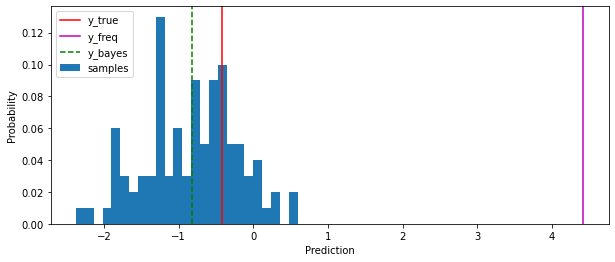

In [61]:
i = 10; j = 3;
#data = [y_pred[i,j] for y_pred in preds]

fig, ax = plt.subplots(figsize=(10, 4))

ax.hist(data, bins=25, weights=(1/n_samples)*np.ones(n_samples), label='samples')
ax.axvline(y_true[i,j], linestyle='solid', color='r', label='y_true')
ax.axvline(y_freq[i,j], linestyle='solid', color='m', label='y_freq')
ax.axvline(y_bayes[i,j], linestyle='dashed', color='g', label='y_bayes')
#ax.axvline(np.median(data), linestyle='dashed', color='m', label='median')
        
ax.set_xlabel('Prediction')
ax.set_ylabel('Probability')

ax.legend()

In [3]:
import tensorflow as tf
import bayesian_builder as builder
tf.keras.backend.clear_session()
model = builder.build_ffn_vae(n_features=512, n_targets=140, latent_dim=64, units=[256, 128], data_size=70000)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          131328      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256)          1024        dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       batch_normalization[0][0]        
______________________________________________________________________________________________

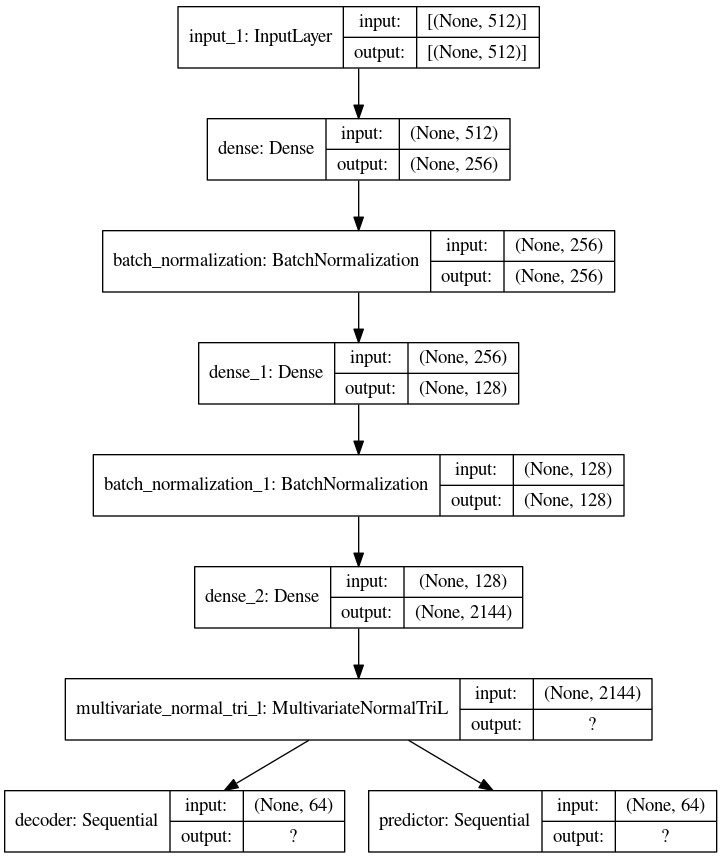

In [2]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [52]:
X_test = pd.read_hdf(FP_CITE_TEST_INPUTS)
X_test_27678 = pd.read_hdf(FP_CITE_TEST_INPUTS_day_2_donor_27678)
X_unlabeled = pd.concat([X_test[7476:], X_test_27678], axis=0)

In [21]:
X_train = pd.read_hdf(FP_CITE_TRAIN_INPUTS)
X_train.head()

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,4.090185,0.0
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.00000,0.000000,0.000000,0.0
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.0,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.00000,3.847321,3.847321,0.0
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.0,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.00000,3.436846,4.113780,0.0
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.0,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.51861,4.196826,3.518610,0.0


In [22]:
X_train.index

Index(['45006fe3e4c8', 'd02759a80ba2', 'c016c6b0efa5', 'ba7f733a4f75',
       'fbcf2443ffb2', 'd80d84ca8e89', '1ac2049b4c98', '33fb0c29e2e4',
       'b329261bd0ee', '703762287e88',
       ...
       'f901120ab887', 'e3780c598532', '663da056425f', '10b466d6898b',
       '4d22a430b2b8', '650ee456f0f3', 'cc506e7707f5', 'a91f1b55a520',
       '3a9882c98205', 'c91b6b2ccd3d'],
      dtype='object', name='cell_id', length=70988)

In [23]:
metadata_df = pd.read_csv(FP_CELL_METADATA)
metadata_df = pd.read_csv(FP_CELL_METADATA, index_col='cell_id')
#metadata_df = metadata_df[metadata_df.technology=="citeseq"]
metadata_df.head()

,day,donor,cell_type,technology
cell_id,,,,
c2150f55becb,2,27678,HSC,citeseq
65b7edf8a4da,2,27678,HSC,citeseq
c1b26cb1057b,2,27678,EryP,citeseq
917168fa6f83,2,27678,NeuP,citeseq
2b29feeca86d,2,27678,EryP,citeseq


In [29]:
metadata_df2 = pd.read_csv(os.path.join(PATH_DATA, "metadata_cite_day_2_donor_27678.csv"))

In [31]:
set(metadata_df.index) & set(metadata_df2.index)

set()

In [ ]:
dstype = 'cite'
for key in ['train', 'test', 'unlabeled']:
    meta = np.load(os.path.join(PATH_WORKING, f'metadata_{dstype}', f'X_{key}.npy'))
    print(key)
    print('min:', meta.min(axis=0))
    print('max:', meta.max(axis=0))

In [1]:
from bayesian_builder3 import *

n_features = {'cite': 512, 'multi': 512}
n_targets = {'cite': 140, 'multi': 512}
latent_dim = 64
units = [256, 128]
data_size = {'cite': 70000, 'multi': 100000}

model = CellModel(n_features, n_targets, latent_dim, units, data_size)

2022-10-31 12:43:21.210188: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/hadoop/lib/native/:/usr/local/cuda-9.0/targets/x86_64-linux/lib/:/usr/local/cuda-9.0/targets/x86_64-linux/lib64/:/usr/hadoop/lib/native/:/usr/local/cuda-9.0/targets/x86_64-linux/lib/:/usr/local/cuda-9.0/targets/x86_64-linux/lib64/::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/hadoop/lib/native:/usr/hadoop/lib/native/Linux-amd64-64
2022-10-31 12:43:21.210258: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TF version: 2.6.0
TFP version: 0.14.0


2022-10-31 12:43:23.436915: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/hadoop/lib/native/:/usr/local/cuda-9.0/targets/x86_64-linux/lib/:/usr/local/cuda-9.0/targets/x86_64-linux/lib64/:/usr/hadoop/lib/native/:/usr/local/cuda-9.0/targets/x86_64-linux/lib/:/usr/local/cuda-9.0/targets/x86_64-linux/lib64/::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/hadoop/lib/native:/usr/hadoop/lib/native/Linux-amd64-64
2022-10-31 12:43:23.437118: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/hadoop/lib/native/:/usr/local/cuda-9.0/targets/x86_64-linux/lib/:/usr/local/cuda-9.0/target

In [2]:
import numpy as np
feat = np.random.randn(16, 512)
meta = np.random.randint(0, 2, (16,4))

inputs = {'cite': np.concatenate([feat, meta], axis=1).astype('float32'), 
          'multi': np.concatenate([feat, meta], axis=1).astype('float32')}

targets = {'cite': np.random.randn(16, n_targets['cite']).astype('float32'), 
           'multi': np.random.randn(16, n_targets['multi']).astype('float32')}

outputs = model.predict(inputs)
outputs['cite'].shape

2022-10-31 12:43:26.913692: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(16, 140)

In [3]:
model.summary()

Model: "cell_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_metadata (Embeddin multiple                  32        
_________________________________________________________________
main_prior (MainPrior)       multiple                  534228    
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
encoder_cite (Sequential)    multiple                  443872    
_________________________________________________________________
encoder_multi (Sequential)   multiple                  443872    
_________________________________________________________________
decoder_cite (Sequential)    multiple                  304512    
_________________________________________________________________
decoder_multi (Sequential)   multiple                  3

In [6]:
t = tf.constant([[1, 2, 3], [4, 5, 6]])
tf.zeros_like(t)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[0, 0, 0],
       [0, 0, 0]], dtype=int32)>

In [17]:
tfpl.MultivariateNormalTriL.params_size(140) * 64

10010